In [14]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
# Read data
# gotten from https://www.ucsusa.org/resources/satellite-database
raw_df = pd.read_excel("../data/UCS-Satellite-Database-5-1-2022.xls")
raw_df.head()

,"Name of Satellite, Alternate Names",Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,...,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66
0,1HOPSAT-TD (1st-generation High Optical Perfor...,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,Infrared Imaging,LEO,Non-Polar Inclined,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aalto-1,Aalto-1,Finland,Finland,Aalto University,Civil,Technology Development,NaN,LEO,Sun-Synchronous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAUSat-4,AAUSat-4,Denmark,Denmark,University of Aalborg,Civil,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"ABS-2 (Koreasat-8, ST-3)",ABS-2,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABS-2A,ABS-2A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
df = raw_df.rename({'Name of Satellite, Alternate Names': "Name"}, axis=1)
df = df.rename({'Date of Launch': "launch_date"}, axis=1)
# Handle dates properly
df['launch_date'] = pd.to_datetime(df['launch_date'])
df.index = df.launch_date
df = df[~df.index.isna()]
df = df[df["Class of Orbit"] == "LEO"]
df = df[df["Purpose"] == "Communications"]
df.shape

(3108, 67)

In [86]:
# Make a note that the indexing happends at the end of each week as seen below
test = df[df["Name"].str.lower().str.contains("starlink")]
print(test)
test.groupby([pd.Grouper(key='launch_date', freq='W-MON')])["Name"].count().reset_index()

                      Name Current Official Name of Satellite  \
launch_date                                                     
2019-11-11   Starlink-1007                      Starlink-1007   
2019-11-11   Starlink-1008                      Starlink-1008   
2019-11-11   Starlink-1009                      Starlink-1009   
2019-11-11   Starlink-1010                      Starlink-1010   
2019-11-11   Starlink-1011                      Starlink-1011   
...                    ...                                ...   
2019-05-24    Starlink-68                        Starlink-68    
2019-05-24    Starlink-70                        Starlink-70    
2019-05-24    Starlink-71                        Starlink-71    
2019-05-24    Starlink-73                        Starlink-73    
2019-05-24    Starlink-79                        Starlink-79    

            Country/Org of UN Registry Country of Operator/Owner  \
launch_date                                                        
2019-11-11        

,launch_date,Name
0,2019-05-27,13
1,2019-06-03,0
2,2019-06-10,0
3,2019-06-17,0
4,2019-06-24,0
...,...,...
149,2022-04-04,0
150,2022-04-11,0
151,2022-04-18,0
152,2022-04-25,53


In [87]:
# Get daily/weekly summation of launches
def get_counts(df, regex, negate=False):
    if negate:
        subset = df[~(df["Name"].str.lower().str.contains(regex).values)]
    else:
        subset = df[(df["Name"].str.lower().str.contains(regex).values)]
    weekly = subset.groupby([pd.Grouper(key='launch_date', freq='W-MON')])["Name"].count().reset_index()
#     counts = subset.groupby([pd.Grouper(key='launch_date', freq='D')])["Name"].count().reset_index()
    weekly.columns = ["launch_date", "count"]
    weekly["cumsum"] = weekly["count"].cumsum()
    weekly.index = weekly.launch_date
    return weekly

In [88]:
starlink = get_counts(df, "starlink")
oneweb = get_counts(df, "oneweb")
neither = get_counts(df, "starlink|oneweb", negate=True)

(2558.0, 2731.0)

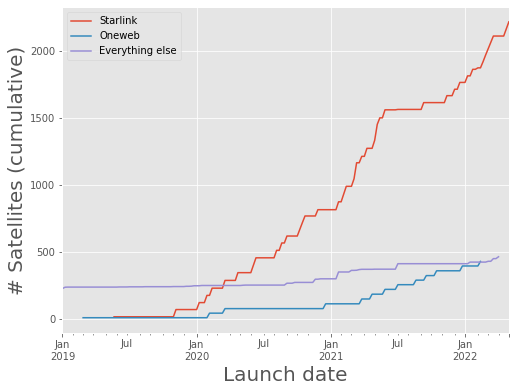

In [89]:


plt.style.use('ggplot')
starlink["cumsum"].plot(figsize=(8,6), label="Starlink") 
oneweb["cumsum"].plot(label="Oneweb") 
neither["cumsum"].plot(label="Everything else") 
plt.ylabel("# Satellites (cumulative)", fontsize=20)
plt.xlabel("Launch date", fontsize=20)
plt.legend()
plt.xlim([np.datetime64("2019-01-01"), np.datetime64("2022-05-01")])

In [93]:
death = pd.read_csv("../data/state_centered_2023.csv")
death.index = pd.to_datetime(death["Week.Ending.Date"])
death.head()

,Unnamed: 0,State,flu_like_deaths,detrended,detrended_flu_like,median,std,median_flu_like,Week.Ending.Date,Total.Deaths,...,MMWR.Week,centered,centered_high,centered_low,centered_flu_like,non_flu_deaths,detrended_non_flu_like,centered_non_flu_like,centered_non_flu_like_high,centered_non_flu_like_low
Week.Ending.Date,,,,,,,,,,,,,,,,,,,,,
2014-01-04,1,Alabama,38.0,1057.000000,38.0,1067.139241,84.816038,41.0,2014-01-04,1057,...,1,-10.139241,159.492835,-179.771316,-3.0,1019.0,1019.000000,-7.139241,162.492835,-176.771316
2014-01-11,2,Alabama,37.0,1076.721519,37.0,1081.360759,85.000592,39.0,2014-01-11,1077,...,2,-4.639241,165.361943,-174.640424,-2.0,1040.0,1039.721519,-2.639241,167.361943,-172.640424
2014-01-18,3,Alabama,34.0,1047.443038,34.0,1034.221519,85.470763,34.5,2014-01-18,1048,...,3,13.221519,184.163046,-157.720008,-0.5,1014.0,1013.443038,13.721519,184.663046,-157.220008
2014-01-25,4,Alabama,42.0,1021.164557,42.0,1005.544304,69.201723,33.0,2014-01-25,1022,...,4,15.620253,154.023700,-122.783194,9.0,980.0,979.164557,6.620253,145.023700,-131.783194
2014-02-01,5,Alabama,26.0,1039.886076,26.0,1056.265823,49.955623,30.0,2014-02-01,1041,...,5,-16.379747,83.531499,-116.290992,-4.0,1015.0,1013.886076,-12.379747,87.531499,-112.290992


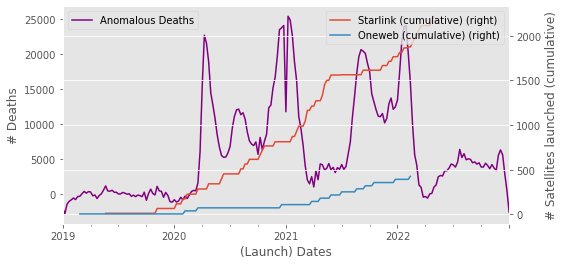

In [94]:

us_death = death[(death.State == "United States") & (death.index.year >= 2019)]

# us_death["Total.Deaths"].plot(label="Deaths")
ax1 = us_death["centered"].plot(figsize=(8,4), label="Anomalous Deaths", color="purple")
# plt.legend(loc="upper left")
ax1.set_ylabel("# Deaths")

# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('axes', 1.0))
starlink["cumsum"].plot(ax=ax1, label="Starlink (cumulative)", secondary_y=True) 
oneweb["cumsum"].plot(ax=ax1, label="Oneweb (cumulative)", secondary_y=True) 
# starlink["count"].plot(ax=ax1, label="Starlink (weekly)", secondary_y=True) 
# oneweb["count"].plot(ax=ax1, label="Oneweb (weekly)", secondary_y=True) 
ax1.right_ax.set_ylabel("# Satellites launched (cumulative)")
first_legend = plt.legend(handles=[ax1.lines[0]], loc='upper left')
ax1.right_ax.set_xlabel("(Launch) Dates")
plt.gca().add_artist(first_legend)
plt.legend(handles=ax1.right_ax.lines, loc='upper right')
ax1.set_xlabel("(Launch) Dates")
plt.savefig("../figures/satellite_death.pdf")

In [95]:
death.index.year

Int64Index([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
            ...
            2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
           dtype='int64', name='Week.Ending.Date', length=25380)

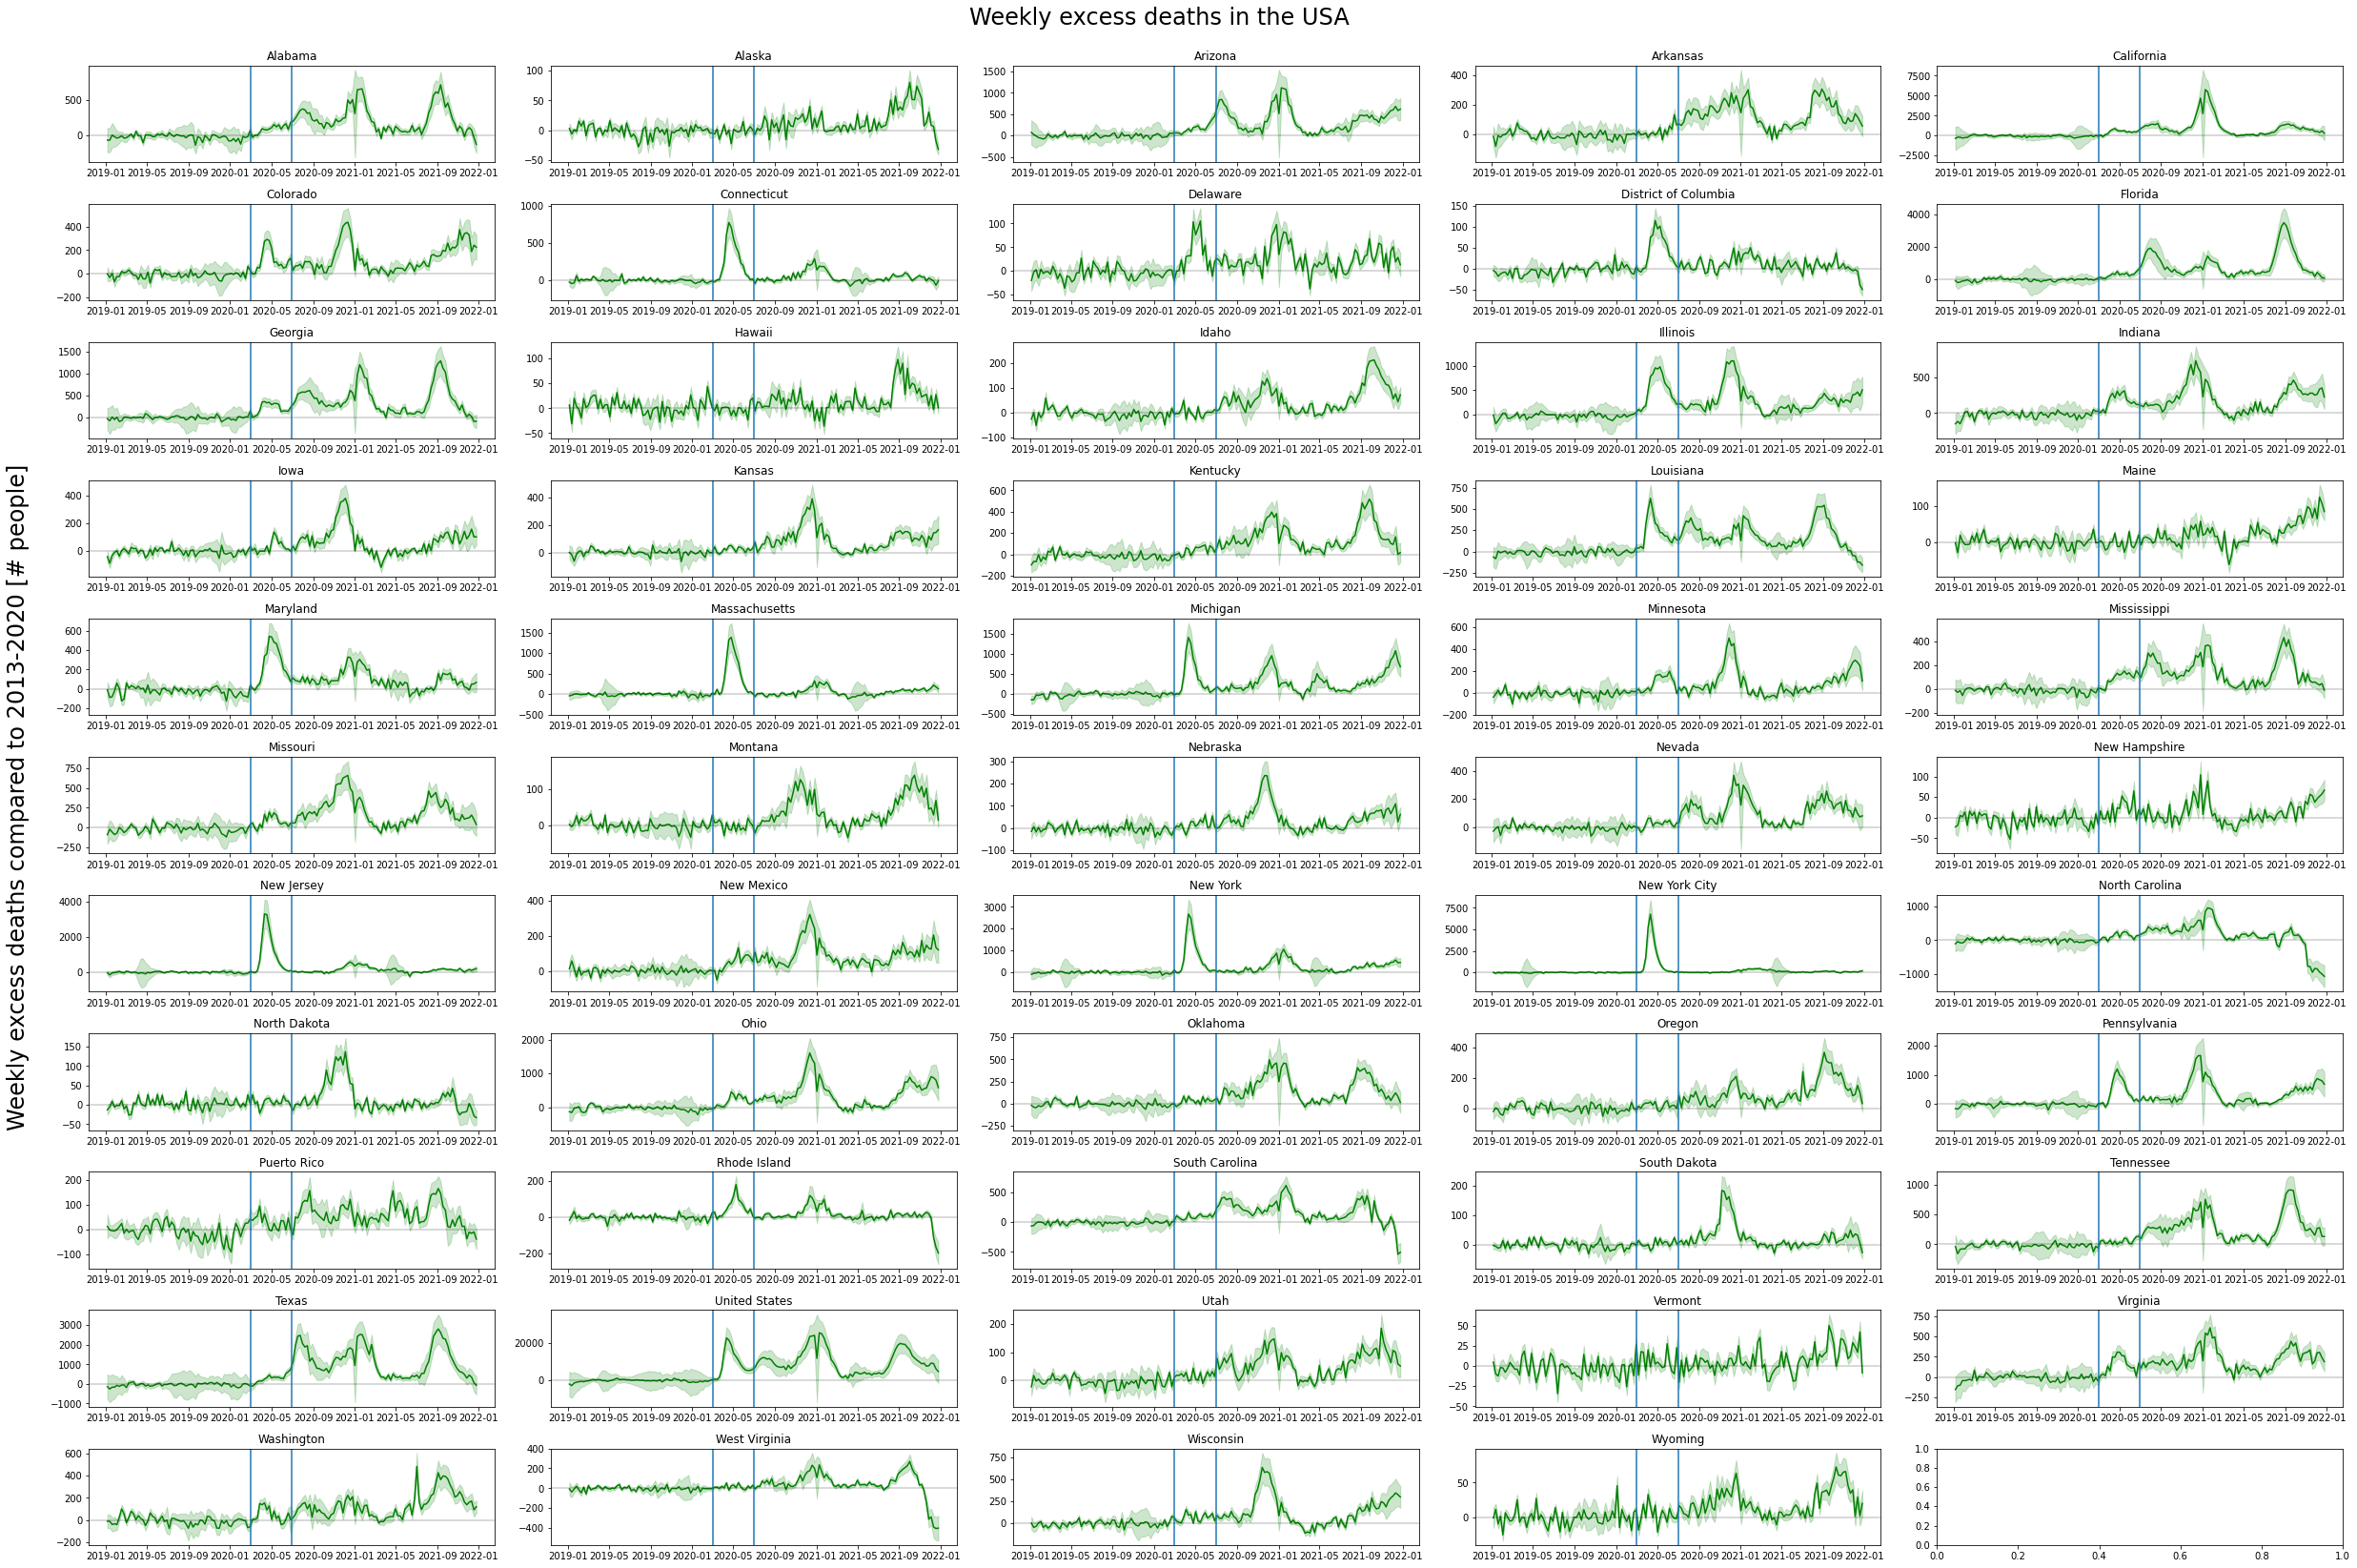

In [51]:
# Find peaks
import datetime
def find_peak(dates, x):
    n = len(x)
    peaks = {}
    for i, x_i in enumerate(x):
        if i < 3 or i > n - 4:
            continue
        if x_i > x[i - 1] and x_i > x[i + 1]:
            
            if x[i - 1] >= x[i - 2] and x[i + 1] >= x[i + 2]:
                if x[i - 2] >= x[i - 3] and x[i + 2] >= x[i + 3]:
                    if x_i > 0.2 * np.max(x):
                        peaks[i] = (dates[i], x_i)
    return peaks
state_peaks = {}
for state, df in death[(death.index.year >= 2019)].groupby(["State"]):
    state_peaks[state] = find_peak(df["Week.Ending.Date"].values, df.centered.values)
    
n_states = len(death.State.unique())
n_cols = 5
n_rows = int(np.ceil(n_states / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(35,24))

i = 0
for state, df in death[(death.index.year >= 2019)].groupby(["State"]):
    j = i % n_cols
    k = i // n_cols
    date = df["Week.Ending.Date"].astype("datetime64[D]")
    axs[k,j].plot(date, df.centered.values, color="green")
    axs[k,j].fill_between(date, df.centered_low.values, df.centered_high.values, color="green", alpha=0.2)
    axs[k,j].set_title(f"{state}")
#     for date, peak in state_peaks[state].values():
#         axs[k,j].plot(datetime.datetime.strptime(date, "%Y-%m-%d"), peak, marker="x", color="red")
    axs[k,j].axvline(datetime.datetime.strptime("2020-03-01", "%Y-%m-%d"))
    axs[k,j].axhline(0, color="black", alpha=0.2)
    axs[k,j].axvline(datetime.datetime.strptime("2020-07-01", "%Y-%m-%d"))
    i += 1

fig.suptitle("Weekly excess deaths in the USA", fontsize=24)
fig.supylabel("Weekly excess deaths compared to 2013-2020 [# people]", fontsize=24)
plt.tight_layout(rect=[0.02, 0.03, 1, 0.98])
plt.savefig(f"../figures/state_mortality.jpg", dpi=100)

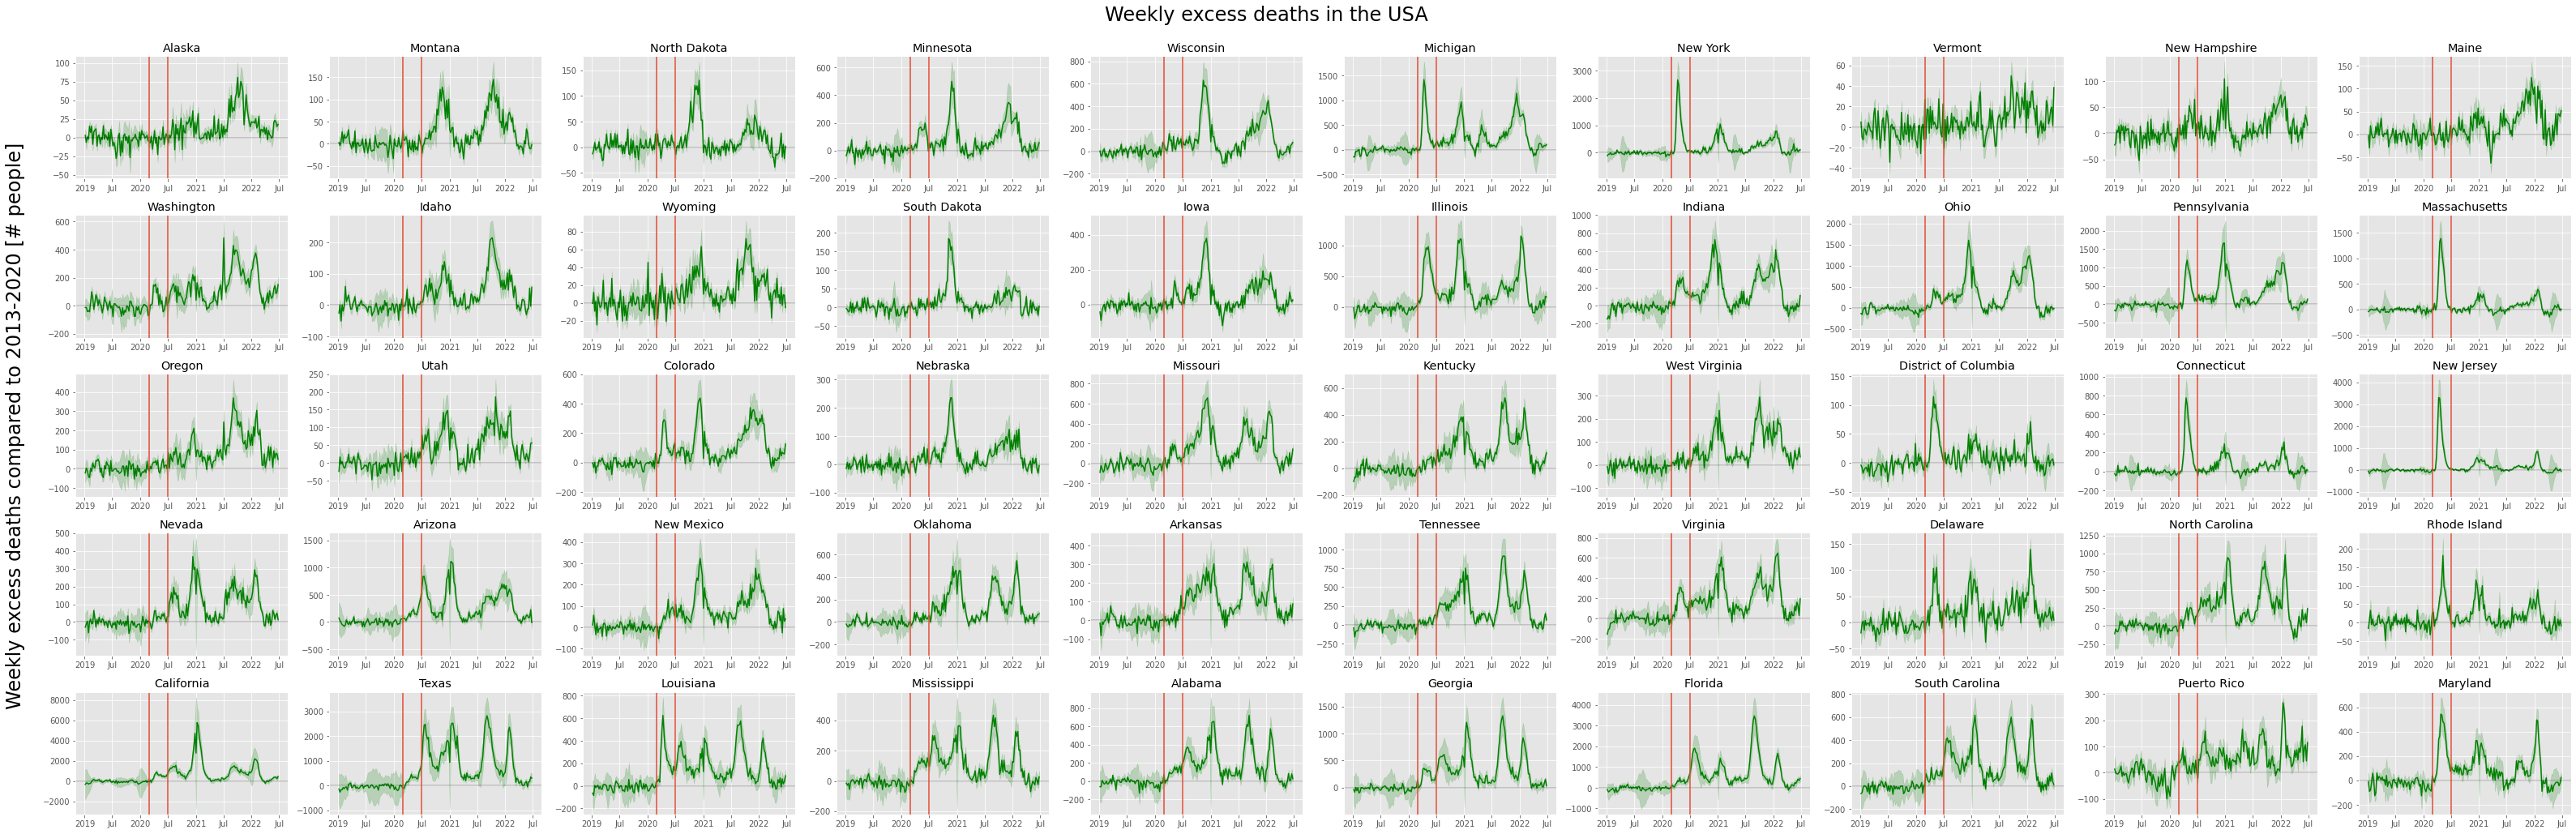

In [98]:
import matplotlib.dates as mdates
n_states = len(death.State.unique())
n_cols = 10
n_rows = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(45,15))

i = 0

states = ["Alaska", "Montana", "North Dakota", "Minnesota", "Wisconsin", "Michigan", "New York", "Vermont", "New Hampshire", "Maine",
         "Washington", "Idaho", "Wyoming", "South Dakota", "Iowa", "Illinois", "Indiana", "Ohio", "Pennsylvania", "Massachusetts",
         "Oregon", "Utah", "Colorado", "Nebraska", "Missouri", "Kentucky", "West Virginia", "District of Columbia", "Connecticut", "New Jersey",
         "Nevada", "Arizona", "New Mexico", "Oklahoma", "Arkansas", "Tennessee", "Virginia", "Delaware", "North Carolina", "Rhode Island",
         "California", "Texas", "Louisiana", "Mississippi", "Alabama", "Georgia", "Florida", "South Carolina", "Puerto Rico", "Maryland"]
for state in states:
    df = death[(death.index.year >= 2019) & (death.index < np.datetime64("2022-07-01")) & (death.State == state)]
    j = i % n_cols
    k = i // n_cols
    date = df["Week.Ending.Date"].astype("datetime64[D]")
    axs[k,j].plot(date, df.centered.values, color="green")
    axs[k,j].fill_between(date, df.centered_low.values, df.centered_high.values, color="green", alpha=0.2)
    axs[k,j].set_title(f"{state}")
#     for date, peak in state_peaks[state].values():
#         axs[k,j].plot(datetime.datetime.strptime(date, "%Y-%m-%d"), peak, marker="x", color="red")
    axs[k,j].axvline(datetime.datetime.strptime("2020-03-01", "%Y-%m-%d"))
    axs[k,j].axhline(0, color="black", alpha=0.2)
    axs[k,j].axvline(datetime.datetime.strptime("2020-07-01", "%Y-%m-%d"))
    axs[k,j].xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(axs[k,j].xaxis.get_major_locator()))
    i += 1

fig.suptitle("Weekly excess deaths in the USA", fontsize=24)
fig.supylabel("Weekly excess deaths compared to 2013-2020 [# people]", fontsize=24)
plt.tight_layout(rect=[0.02, 0.03, 1, 0.98])
plt.savefig(f"../figures/state_mortality_geo.jpg", dpi=100)

In [97]:
import pathlib
import sys
import importlib
scripts_dir = '/Users/matzhaugen/mortality/src'
sys.path.append(scripts_dir) if scripts_dir not in sys.path else None
import helper
importlib.reload(helper)
sird_min_params = (10, 1e-6, 0.001) # gamma, eta, beta
sird_max_params = (10000, 1e-2, 1)
gomp_min_params = (0.01, 0.001, 0.01) # beta, alpha, x_tilde
gomp_max_params = (10, 1., 1.)


In [98]:
state = "New York"
state_peaks_manual = {"New York": ("2020-03", "2020-07-01"),
                     "New Jersey": ("2020-03", "2020-07-01"),
                     "Pennsylvania": ("2020-03-15", "2020-07-01"),
                     "Louisiana": ("2020-03-01", "2020-07-01"),
                     "Massachusetts": ("2020-03-15", "2020-07-01"),
                     "Connecticut": ("2020-03-15", "2020-07-01"),
                     "Maryland": ("2020-03-10", "2020-07-01"),
                     "Illinois": ("2020-03-10", "2020-07-01"),
                     "District of Columbia": ("2020-03-10", "2020-07-01")}
# smooth = {"Maryland"}

In [99]:
import scipy.optimize as spo
import statsmodels.api as sm
from scipy.ndimage import convolve1d
maxd = {}
popt_gomp = {}
popt = {}
xinf = {}
pcov = {}
pcov_gomp = {}
D_gomp = {}
D_sird = {}
norm_deaths = {}
norm_cumsum = {}
p_val = {}
t = {}
dates = {}


def test_sird(x):
    # Inspired by Frances 1994 
    # also: https://www.sciencedirect.com/science/article/abs/pii/S0040162514002170
    z = np.log(np.diff(np.log(x)))
    t = np.arange(len(z))
    exog = np.array([np.ones(len(t)), t, t**2]).T
    model = sm.OLS(endog=z,exog=exog)
    results = model.fit()
    return (results.params[2], results.pvalues[2])

for state, df in death[(death.index.year >= 2019)].groupby(["State"]):
    if state not in state_peaks_manual:
        continue
    y = df[state_peaks_manual[state][0]:state_peaks_manual[state][1]].centered
    dates[state] = df[state_peaks_manual[state][0]:state_peaks_manual[state][1]]["Week.Ending.Date"].astype("datetime64[D]")
    if np.any(y < 0):
        y -= np.min(y) - 10
    x = np.cumsum(y)
    maxd[state] = np.max(x)
    x, y = x / np.max(x), y / np.max(x)
    t0 = max(min(np.arange(len(x))[x/x.max() > 0.005]) - 1, 0)
    x, y = x[t0:].values, y[t0:].values
#     if state in smooth:
#         x, y = convolve1d(x, [.5, .5]), convolve1d(y, [.5, .5])
    norm_deaths[state] = y
    norm_cumsum[state] = x
    dates[state] = dates[state][t0:]
    t[state] = np.arange(np.minimum(50, len(x)))
    popt_gomp[state], pcov_gomp[state] = spo.curve_fit(helper.gomp, x, y, 
                                                           bounds=(gomp_min_params, gomp_max_params),
                                                          jac=helper.gomp_jac)
    xinf[state] = helper.get_gomp_inf(*popt_gomp[state])
    popt[state], pcov[state] = spo.curve_fit(helper.sird, x, y, jac=helper.sird_jac)
    
    
    D_gomp[state] = maxd[state] * helper.gomp_time(t[state], x[0], *popt_gomp[state])
    D_sird[state] = maxd[state] * helper.sird_d_time(t[state], x[0], *popt[state])
    p_val[state] = test_sird(norm_cumsum[state])

/Users/matzhaugen/.pyenv/versions/3.9.4/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     204.5
Date:                Tue, 24 Jan 2023   Prob (F-statistic):           5.36e-10
Time:                        11:12:04   Log-Likelihood:                 3.0242
No. Observations:                  15   AIC:                          -0.04836
Df Residuals:                      12   BIC:                             2.076
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0826      0.151     -0.548      0.594      -0.411       0.246
x1            -0.1773      0.050     -3.548      0.004      -0.286      -0.068
x2            -0.0063      0.003     -1.844      0.090      -0.014       0.001
==============================================================================
Omnibus:                       13.303   Durbin-Watson:                   2.598
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.203
Skew:                          -1.415   Prob(JB):                      0.00609
Kurtosis:                       5.883   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

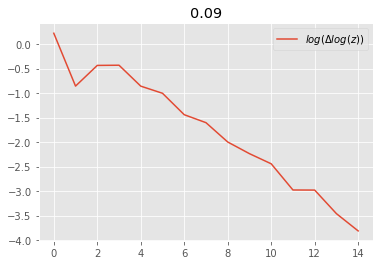

In [100]:
state = "New Jersey"
state = "Pennsylvania"
state = "Louisiana"
state = "Massachusetts"
state = "Connecticut"
state = "Maryland"
state = "Illinois"
state = "District of Columbia"
z = np.log(np.diff(np.log(norm_cumsum[state])))
tt = np.arange(len(z))
exog = np.array([np.ones(len(tt)), tt, tt**2]).T
model = sm.OLS(endog=z,exog=exog)
results = model.fit()
signif = np.round(results.pvalues[2], 2)
plt.plot(z, label=r"$log(\Delta log (z))$")
# plt.plot(results.fittedvalues)
plt.title(f"{signif}")
plt.legend()
results.summary()


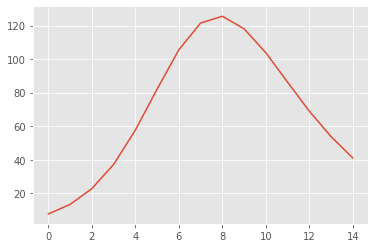

In [101]:
state = "District of Columbia"
p_val[state]
xinf[state]
# maxd[state] * norm_cumsum[state][0]
# D_sird[state]
# plt.plot(maxd[state] * helper.sird_d_time(t[state], norm_cumsum[state][0], *popt[state]))
# plt.plot(maxd[state] * np.diff(helper.sird_d_time(t[state], norm_cumsum[state][5], *popt[state])))
# plt.plot(maxd[state] * np.insert(np.diff(helper.sird_d_time(t[state], norm_cumsum[state][0], *popt[state])), 0, norm_cumsum[state][0]))
plt.plot(np.diff(D_sird[state]))
# np.insert(np.diff(D_sird[state]), 0, maxd[state] * norm_cumsum[state][0])

In [102]:
print(maxd[state] * np.diff(helper.sird_d_time(t[state], norm_cumsum[state][0], *popt[state])))
print(norm_cumsum[state][0] * maxd[state])
print(helper.sird_d_time(t[state], norm_cumsum[state][0], *popt[state]))
print(norm_cumsum[state][0])

[  7.72562115  13.4178555   22.8088535   37.23432626  57.70500747
  82.12654089 105.53312663 121.46663812 125.52297183 118.05501042
 103.77630348  86.25892565  68.96650793  53.7785878   41.09242523]
10.0
[0.00922019 0.01634336 0.02871487 0.04974506 0.08407581 0.13728091
 0.21300312 0.31030664 0.42230116 0.53803569 0.64688462 0.74256832
 0.82210067 0.88568908 0.93527395 0.97316193]
0.009220187499579379


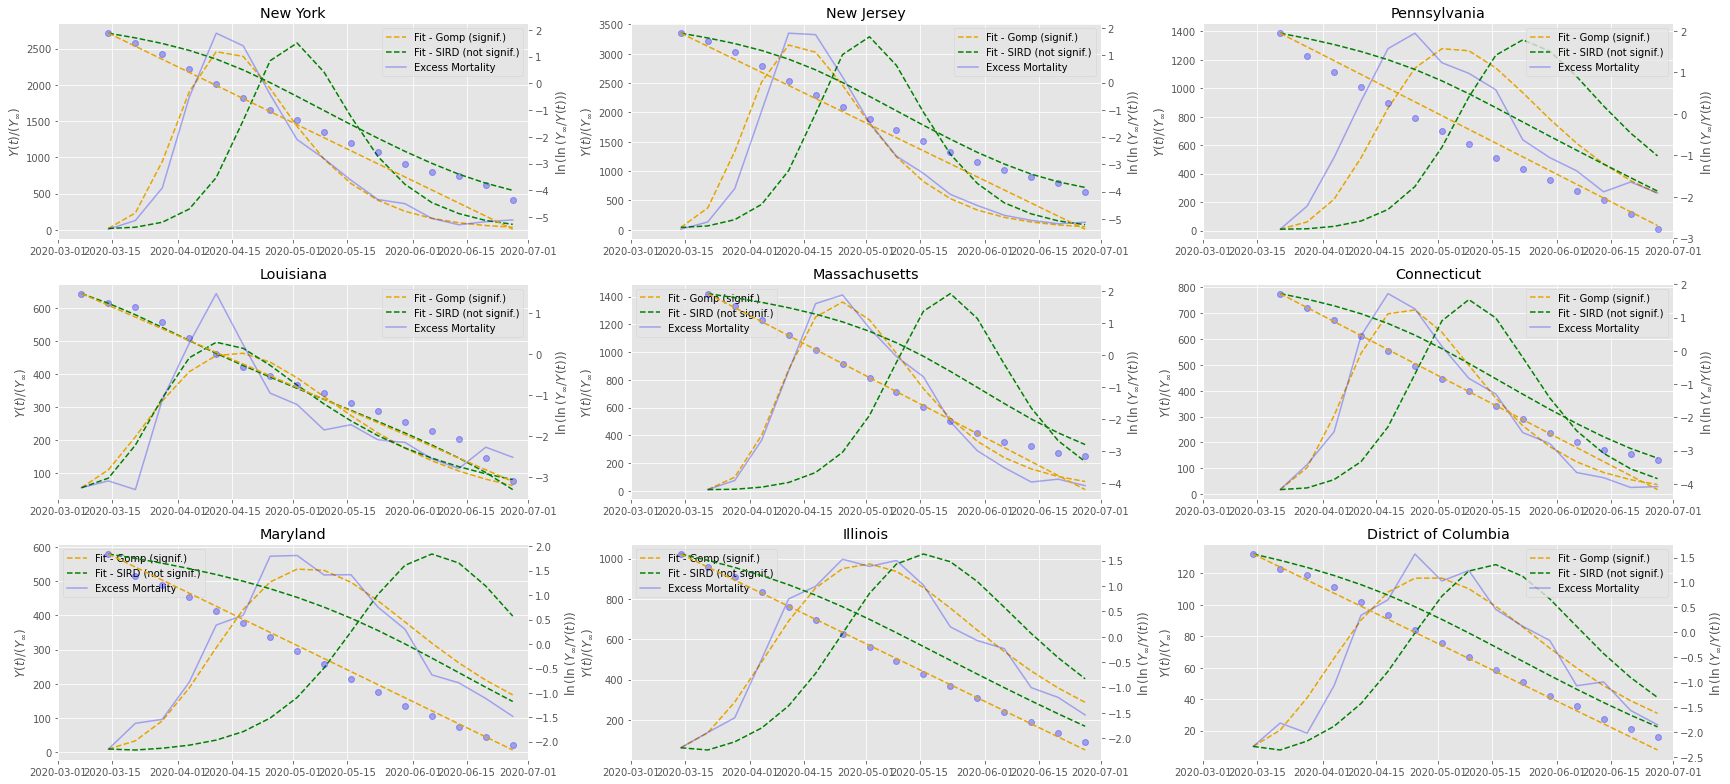

In [103]:
color_gompertz = "#e5a400"
color_sird = "#008000"
color_data = "#0000ff"
n_states = len(state_peaks_manual.keys())
n_cols = 3
n_rows = np.maximum(int(np.ceil(n_states / n_cols)), 2)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(24,11))
min_date = datetime.datetime.strptime("2020-03-01", "%Y-%m-%d")
max_date = datetime.datetime.strptime("2020-07-01", "%Y-%m-%d")
legend_loc = {"District of Columbia": "upper right", "Pennsylvania": "upper right"}
for i, state in enumerate(state_peaks_manual.keys()):
    j = i % n_cols
    k = i // n_cols
    n_y = len(norm_deaths[state])
    label_sird = "Fit - SIRD (signif.)" if p_val[state][1] < 0.05 and p_val[state][0] < 0 else "Fit - SIRD (not signif.)"
    label_gomp = "Fit - Gomp (signif.)" if p_val[state][1] > 0.05 or p_val[state][0] > 0 else "Fit - Gomp (not signif.)"
    sird_dates = dates[state]
    d_hat_gomp = np.insert(np.diff(D_gomp[state]), 0, maxd[state] * norm_cumsum[state][0])
    d_hat_sird = np.insert(np.diff(D_sird[state]), 0, maxd[state] * norm_cumsum[state][0])
    axs[k, j].plot(dates[state], d_hat_gomp, label=label_gomp, color=color_gompertz, linestyle="--")
    axs[k, j].plot(sird_dates, d_hat_sird, label=label_sird, color=color_sird, linestyle="--")
    axs[k, j].plot(dates[state], maxd[state] *  norm_deaths[state], label="Excess Mortality", color=color_data, alpha=0.3)
    if state in legend_loc:
        axs[k, j].legend(loc=legend_loc[state])
    else:
        axs[k, j].legend()
    axs[k, j].set_ylabel(r"$Y(t)/(Y_{\infty})$")
    axs[k, j].set_title(f"{state}")
    ax2 = axs[k, j].twinx()
    ll = helper.safe_lnln(norm_cumsum[state][t[state]], xinf[state])
    ax2.plot(dates[state], ll, ".", color=color_data, alpha=0.3, markersize=12)
    ax2.plot(sird_dates, helper.safe_lnln(D_sird[state], xinf[state]*maxd[state]), label="SIRD", color=color_sird, linestyle="--")
    ax2.plot(dates[state], helper.safe_lnln(D_gomp[state], xinf[state]*maxd[state]), label="Gompertz", color=color_gompertz, linestyle="--")
    ax2.grid(visible=False)
    ax2.set_ylabel(r"$\ln{(\ln{(Y_{\infty}/Y(t))})}$")
    axs[k, j].set_xlim((min_date, max_date))
fig.tight_layout()
# plt.savefig("../figures/state_gompertz_march_june_2020.pdf")

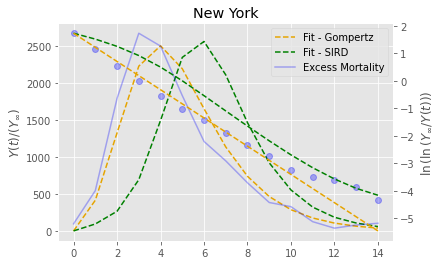

In [229]:
color_gompertz = "#e5a400"
color_sird = "#008000"
color_data = "#0000ff"
for state in state_peaks_manual.keys():
    n_y = len(norm_deaths[state])
    plt.plot(t, np.insert(np.diff(D_gomp[state]), 0, norm_cumsum[state][0]), label="Fit - Gompertz", color=color_gompertz, linestyle="--")
    plt.plot(t, np.insert(np.diff(D_sird[state]), 0, norm_cumsum[state][0]), label="Fit - SIRD", color=color_sird, linestyle="--")
    plt.plot(t, maxd[state] *  norm_deaths[state], label="Excess Mortality", color=color_data, alpha=0.3)
    plt.legend()
    plt.ylabel(r"$Y(t)/(Y_{\infty})$")
    plt.title(f"{state}")
    ax2 = plt.twinx()
    ll = helper.safe_lnln(norm_cumsum[state][t], xinf[state])
    ax2.plot(t, ll, ".", color=color_data, alpha=0.3, markersize=12)
    ax2.plot(t, helper.safe_lnln(D_sird[state], xinf[state]*maxd[state]), label="SIRD", color=color_sird, linestyle="--")
    ax2.plot(t, helper.safe_lnln(D_gomp[state], xinf[state]*maxd[state]), label="Gompertz", color=color_gompertz, linestyle="--")
    ax2.grid(visible=False)
    ax2.set_ylabel(r"$\ln{(\ln{(Y_{\infty}/Y(t))})}$")
    

In [32]:
# Parameters estimated with normalized observations
plt.rcParams['text.usetex'] = True
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria',
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]
m = len(subset)
inflation = 2
popt_gomp = {}
popt = {}
xinf = {}
pcov = {}
pcov_gomp = {}
d, a, r, r_sd = np.zeros(m), np.zeros(m), np.zeros(m), np.zeros(m)
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    x, y = country_data.cumDeaths + 1, country_data.rollDeaths
    maxd[country] = np.max(x)
    x, y = x / np.max(x), y / np.max(x)
    t0 = max(min(np.arange(len(x))[x/x.max() > 0.005]) - 1, 0)
    x, y = x[t0:], y[t0:] 
    t = np.arange(np.maximum(50, len(x) - 1))
    popt[country], pcov[country] = spo.curve_fit(sird, x, y, jac=sird_jac)
    popt_gomp[country], pcov_gomp[country] = spo.curve_fit(gomp, x.values, y.values, 
                                                           bounds=(gomp_min_params, gomp_max_params),
                                                          jac=gomp_jac)
    xinf[country] = get_gomp_inf(*popt_gomp[country])

    gamma, eta, beta = popt[country]
    slope_i = np.round(gamma * eta - beta, 2)
    mu, var_mu = 0.012, 0.005**2 # death / (death + recovery) ratio
    dx0 = (x[1] - x[0] + x[2] - x[1]) / 2
#     dx0 = (x[1] - x[0])
    gamma_orig, eta_orig, beta_orig = popt_orig[country]
    _, d[n], a[n], _, _ = sird_time(t, dx0, x[1], mu, *popt[country], norm=False)
    D_sird = maxd[country] * sird_d_time(t, x[0], *popt[country])
#     print(get_b_k(*popt[country]))
#     D_sird = sird_d_time(t, x[0], *popt[country])
    D_gomp = maxd[country] * gomp_time(t, x[0], *popt_gomp[country])
    ll = safe_lnln(x[t], xinf[country])
    plt.plot(t, ll, ".", color="#0000ff", alpha=0.3)
    plt.plot(t, safe_lnln(D_sird, xinf[country]*maxd[country]), label="SIRD", color="#008000")
    plt.plot(t, safe_lnln(D_gomp, xinf[country]*maxd[country]), label="Gompertz", color="#e5a400")
#     plt.plot(t, safe_lnln(D_sird), label="SIRD", color="#008000")
#     plt.plot(t, safe_lnln(D_gomp), label="Gompertz", color="#e5a400")

    axs[i, j].set_ylim((np.min(ll), 2.5))
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    yscale = ymax-ymin
    x_alpha = 0.90
    y_alpha = 0.90

    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    if i == 3 and j == 3:
        x_alpha = 0.40
        y_alpha = 0.70    
        xloc = xmin * (1-x_alpha) + xmax * (x_alpha)
        yloc = ymin * (1-y_alpha) + ymax * (y_alpha)

    plt.text(xloc, yloc + yscale*0.12, country, fontsize=11)
    plt.text(xloc, yloc, r"$R_0$: " + f"{R0[n]:.2f} ({R0_sd[n]:.2f})", fontsize=11)
    if j == 0:
        plt.ylabel(r"$\ln{(\ln{(Y_{\infty}/Y(t))})}$")
    if i == 3:
        plt.xlabel("Days")
    if n == 0:
        plt.legend(loc="upper right")
    plt.grid(True)

plt.savefig("../figures/Gompertz_vs_SIRD_lnln_infty.pdf")

Week.Ending.Date
2019-01-05   2019-01-05
2019-01-12   2019-01-12
2019-01-19   2019-01-19
2019-01-26   2019-01-26
2019-02-02   2019-02-02
                ...    
2021-11-27   2021-11-27
2021-12-04   2021-12-04
2021-12-11   2021-12-11
2021-12-18   2021-12-18
2021-12-25   2021-12-25
Name: Week.Ending.Date, Length: 156, dtype: datetime64[ns]

In [ ]:
# Import solar time
# import vaccination